In [1]:
from datasets import load_dataset
from glob import glob
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavel.belenko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavel.belenko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---
### Задача: научиться распознавать эмоциональную окраску текста.

Для анализа выбрал датасет: https://huggingface.co/datasets/zloelias/kinopoisk-reviews

Данные представляют из себя отзывы пользователей кинопоиска о фильмах, причём каждому отзыву сопоставлено, является он позитивным (positive), или негативным (negative):


In [2]:
dataset = load_dataset("zloelias/kinopoisk-reviews")

data_path = "kinopoisk_data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

for name in ["train", "test"]:
    df = pd.DataFrame(dataset[name])
    df.to_csv("{}/{}.csv".format(data_path, name), encoding="utf-8", index=False)

df.tail()

Using custom data configuration zloelias--kinopoisk-reviews-648d3606d8d66ff0
Found cached dataset parquet (C:/Users/pavel.belenko/.cache/huggingface/datasets/zloelias___parquet/zloelias--kinopoisk-reviews-648d3606d8d66ff0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

text  labels label_name  \
8198  На этот фильм я наткнулась совершенно случайно...       1   negative   
8199  Фильм слащаво-приторный и слишком прямолинейны...       1   negative   
8200  17-й век, местные жители терроризируют еврейск...       1   negative   
8201  Когда я впервые увидела сериал по телевизору, ...       0   positive   
8202  Есть фильмы после которых, остается что-то в д...       1   negative   

      __index_level_0__  
8198               5876  
8199              10786  
8200              12495  
8201              55264  
8202               1593

---
### Предобработка:

- удаление знаков препинания,
- приведение к одному регистру
- токенизация
- удаление стоп-слов
- леммантизация

In [3]:
def review_preprocess(review):

    review = re.sub(r'[^\w\s]', '', review)
    review = re.sub(r'\n', '', review)
    review = review.lower()

    list_of_words = word_tokenize(review, language="russian")

    preprocessed_review = []
    for word in list_of_words:
        if word not in ru_stops:
            p =  morph.parse(word)[0]
            preprocessed_review.append(p.normal_form)

    return ' '.join(preprocessed_review)


def get_data(path, vocab):

    """negative == 1
        positive == 0"""

    review_dict = {0: [], 1: []}
    data_df = pd.read_csv(path)

    for i in range(len(data_df)):
        clean_review = review_preprocess(data_df["text"][i])
        review_dict[int(data_df["labels"][i])].append(clean_review)
        vocab.update(clean_review.split())

    return review_dict

vocab = Counter()
ru_stops = set(stopwords.words('russian'))
morph = MorphAnalyzer()

test_dict = get_data(glob("{}/*.csv".format(data_path))[0],vocab)
train_dict = get_data(glob("{}/*.csv".format(data_path))[1], vocab)
test_dict[1][0]

'грязный мерзкий зрелище просмотр жалеть эмоция смыть унитаз вместо забавный комедия который должный планироваться изначально получиться винегрет вульгарщина похотливый разврат нынче милый душа хаваета современный обременить интеллект богатый внутренний мир молодёжь единственный улыбнуть весь фильм это псевдосвященник который совместительство вещать текст лицо автор вести церемония свадьба это нечто весь остальной бред страдать недотрх молодёжь простить французский говориться сцена коровник думать сам сказать закомплексованный план дело интимный пардон гражданин пикантный интим похабный вульгарщина видеть последнеедва балл этот отстой милый псевдосвященник'

In [4]:
word_list = sorted(vocab, key=vocab.get, reverse=True)
vocab_to_int = {word:idx+1 for idx, word in enumerate(word_list)}
int_to_vocab = {idx:word for word, idx in vocab_to_int.items()}

word_list[:10]

['фильм',
 'это',
 'который',
 'свой',
 'человек',
 'очень',
 'герой',
 'такой',
 'просто',
 'один']

In [5]:
data_path = "kinopoisk_data_preprocessed"
if not os.path.exists(data_path):
    os.makedirs(data_path)

data = {"train": train_dict, "test": test_dict}
for name in ["train", "test"]:
    df = pd.DataFrame()
    df['text'] = data[name][0] + data[name][1]
    df['label'] = [0]*len(data[name][0]) + [1]*len(data[name][1])
    df = df.sample(frac=1).reset_index(drop=True)
    df.to_csv("{}/{}.csv".format(data_path, name), encoding="utf-8", index=False)

---
Необходим down sampling. Oбучение на полном объёме не представлянется возможным на моём устройстве (даже учитывая наличие видеокарты).
Заодно можно сбалансировать классы:


In [6]:
print('Before Down Sampling the training set :')
print('Number of negative reviews in train set :',len(train_dict[1]))
print('Number of positive reviews in train set :',len(train_dict[0]))

for i in [0, 1]:
    #train_dict[i]=train_dict[i][:int(len(train_dict[i])*.5)]
    train_dict[i]=train_dict[i][:7250]

print('\nAfter Down Sampling :')
print('Number of negative reviews in train set :',len(train_dict[1]))
print('Number of positive reviews in train set :',len(train_dict[0]))

Before Down Sampling the training set :
Number of negative reviews in train set : 26749
Number of positive reviews in train set : 47071

After Down Sampling :
Number of negative reviews in train set : 7250
Number of positive reviews in train set : 7250


---
DataLoaders:

In [7]:
class KinopoiskReviewDataset(Dataset):

    def __init__(self, review_dict, alphabet):

        self.data = review_dict
        self.labels = [x for x in review_dict.keys()]
        self.alphabet = alphabet

    def __len__(self):
        return sum([len(x) for x in self.data.values()])

    def __getitem__(self, idx):
        label = 0

        while idx >= len(self.data[self.labels[label]]):
            idx -= len(self.data[self.labels[label]])
            label += 1

        review_text = self.data[self.labels[label]][idx]

        label_vec = torch.zeros((1), dtype=torch.long)
        label_vec[0] = label
        return text_to_vec(review_text), label


def text_to_vec(review_text):

    review_text_vec = torch.zeros((len(review_text)), dtype=torch.long)

    for pos,word in enumerate(review_text.split()):

        if word not in vocab_to_int.keys():
            review_text_vec[pos]=0
        else:
            review_text_vec[pos]=vocab_to_int[word]

    return review_text_vec


def pad_and_pack(batch):

    input_tensors = []
    labels = []
    lengths = []

    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0])

    if len(input_tensors[0].shape) == 1:
        x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    else:
        raise Exception('Current implementation only supports (T) shaped data')

    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    return x_packed, y_batched

train_batch_size = 24
train_dataset = KinopoiskReviewDataset(train_dict, vocab)
test_dataset = KinopoiskReviewDataset(test_dict, vocab)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

---
Решено было использовать рекурентные сети. Реализовал RNN и LSTM из книги по PyTorch:
https://www.rulit.me/data/programs/resources/pdf/Poynter_Programmiruem-s-PyTorch_RuLit_Me_676986.pdf?ysclid=l977ovsy1d270896797

In [8]:
class EmbeddingPackable(nn.Module):

    """
    The embedding layer in PyTorch does not support Packed Sequence objects.
    This wrapper class will fix that. If a normal input comes in, it will
    use the regular Embedding layer. Otherwise, it will work on the packed
    sequence to return a new Packed sequence of the appropriate result.
    """

    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):

        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input,
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to("cpu"),
                                                           batch_first=True, enforce_sorted=False)
        else:  #apply to normal data
            return self.embd_layer(input)


class LastTimeStep(nn.Module):

    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """

    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1]
        if (type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]  #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'

        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers - 1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)


def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None,
                  epochs=10, device="cpu", checkpoint_file=None,
                  lr_schedule=None, optimizer=None, disable_tqdm=False
                  ):

    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- compute lodation to perform training

    """

    if score_funcs is None:
        score_funcs = {}  #Empty set

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score)
        if val_loader is not None:
            to_track.append("val " + eval_score)

    total_train_time = 0  #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer is None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):

        model = model.train()  #Put our model in training mode
        running_loss = 0.0

        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):

            #Move the batch to the device we are using.
            inputs = inputs.to(device)
            labels = labels.to(device)

            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs)  #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()  # ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters!
            optimizer.step()  # Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size

            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i, :])
        #end training epoch
        end = time.time()
        total_train_time += (end - start)

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)
        results["train loss"].append(running_loss)

        y_pred = np.asarray(y_pred)

        if y_pred.shape[1] > 1:  #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)

        for name, score_func in score_funcs.items():
            results["train " + name].append(score_func(y_true, y_pred))

        if val_loader is None:
            pass
        else:  #Lets find out validation performance as we go!
            model = model.eval()  #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []

            val_running_loss = 0.0

            for inputs, labels in val_loader:

                #Move the batch to the device we are using.
                inputs = inputs.to(device)
                labels = labels.to(device)

                batch_size = labels.shape[0]

                y_hat = model(inputs)

                loss = loss_func(y_hat, labels)

                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i, :])

            results["val loss"].append(running_loss)

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1:  #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append(score_func(y_true, y_pred))

        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()

        if not checkpoint_file is None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

---
**RNN 3 Layer Bidirectional Model**

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

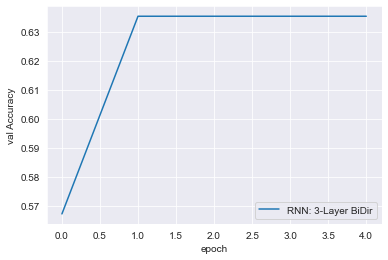

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

D = 32
alphabet_size = len(vocab) + 1
hidden_nodes = 64
classes = len(train_dataset.labels)

rnn = nn.Sequential(
    EmbeddingPackable(nn.Embedding(alphabet_size, D)),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    LastTimeStep(rnn_layers=3, bidirectional=True),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes * 2, classes),  #(B, D) -> (B, classes)
)

rnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(rnn.parameters(), lr=0.001 * train_batch_size)
epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
rnn_results = train_network(rnn, loss_func, train_loader, val_loader=test_loader,
                            epochs=epochs, optimizer=optimizer, lr_schedule=scheduler,
                            score_funcs={'Accuracy': accuracy_score},
                            checkpoint_file='rnn_model.pt', device=device)

sns.lineplot(x='epoch', y='val Accuracy', data=rnn_results, label='RNN: 3-Layer BiDir')

<AxesSubplot:xlabel='total time', ylabel='val Accuracy'>

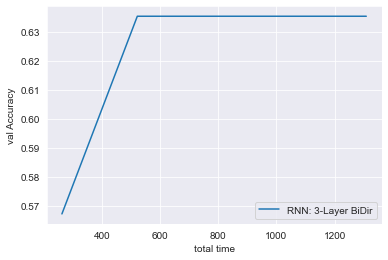

In [10]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_results, label='RNN: 3-Layer BiDir')

In [11]:
with torch.no_grad():

    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = rnn(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 5212/8203 =  63.538%


---
**LSTM 3 Layer Bidirectional Model**

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/605 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

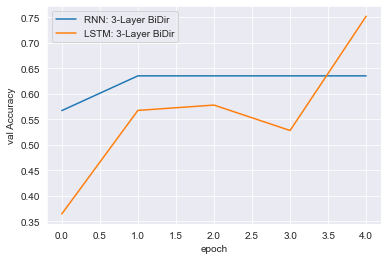

In [12]:
lstm = nn.Sequential(
    EmbeddingPackable(nn.Embedding(alphabet_size, D)),  #(B, T) -> (B, T, D)
    nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    LastTimeStep(rnn_layers=3, bidirectional=True),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes * 2, classes),  #(B, D) -> (B, classes)
)

lstm.to(device)
optimizer = torch.optim.AdamW(lstm.parameters(), lr=0.001 * train_batch_size)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
lstm_results = train_network(lstm, loss_func, train_loader, val_loader=test_loader,
                             epochs=epochs, optimizer=optimizer, lr_schedule=scheduler,
                             score_funcs={'Accuracy': accuracy_score},
                             checkpoint_file='lstm_model.pt', device=device)

sns.lineplot(x = 'epoch', y = 'val Accuracy', data = rnn_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = lstm_results, label='LSTM: 3-Layer BiDir')

<AxesSubplot:xlabel='total time', ylabel='val Accuracy'>

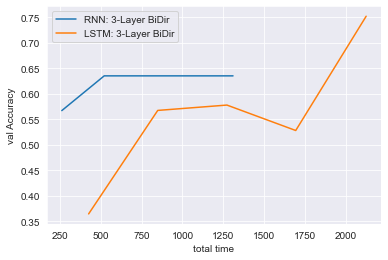

In [13]:
sns.lineplot(x='total time', y='val Accuracy', data = rnn_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x='total time', y='val Accuracy', data = lstm_results, label='LSTM: 3-Layer BiDir')

In [14]:
with torch.no_grad():
   correct = 0
   for X_test, y_test in test_loader:
       X_test=X_test.to(device)
       y_test=y_test.to(device)
       y_val = lstm(X_test)
       predicted = torch.max(y_val,1)[1]
       correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 6171/8203 =  75.229%
